In [210]:
import vk
import re
import datetime
import os

token_re=re.compile('access_token=([0-9a-z]+)')
user_id_re=re.compile('user_id=([0-9]+)')

def parce_uri(uri):
    match_tok=re.search(token_re,uri)
    match_us_id=re.search(user_id_re,uri)
    if match_tok and match_us_id:
        return match_us_id.group(1),match_tok.group(1)
    else:
        raise exceptions.KeyError(uri)

test_uri="https://oauth.vk.com/blank.html#access_token=581a17b2c4cba7fbcd12e073156d3053993972ea5679adf6244b3b5ad5a099aa265b6e343eec128d6e1ea&expires_in=86400&user_id=4061100"
user_id,token=parce_uri(test_uri)
api = vk.API(access_token=token)

In [211]:
def load_posts(api,domain,max_items = 500):
    offset=0
    not_empty_response=True
    items = []
    
    while not_empty_response and len(items) < max_items:
        try:
            response = api('wall.get', domain=domain,count=100,offset=offset)
            if 'items' in response:
                items += response['items']
                offset += 100
            else:
                not_empty_response = False
        except Exception,e:
            try:
                print str(e)
            except:
                pass
            time.sleep(2)
        if len(items)%200 == 0: print len(items)
    
    return [ {'post_id':i['id'],'owner_id':i['owner_id'],'text':i['text'],'date':i['date']} for i in items ]

def make_two_try_and_deleys(fn):
    def wrapper(*params,**named_params):
        time.sleep(1)  
        try:
            return fn(*params,**named_params)
        except Exception,e:
            print str(e)
            time.sleep(2)
            try:
                return fn(*params,**named_params)
            except Exception,e:
                print "second error"
        return []
    return wrapper
    
@make_two_try_and_deleys    
def load_comments(api,owner_id,post_id):
    response = api('wall.getComments', owner_id=owner_id,post_id=post_id,count=1000)
    return [ {"id":i["id"],"from_id":i["from_id"],'date':i['date'],"text":i["text"]} for i in response['items'] if i["text"] != '' ]    
    
@make_two_try_and_deleys    
def load_reposts(api,owner_id,post_id):
    response = api('wall.getReposts', owner_id=owner_id,post_id=post_id,count=1000)
    return [ {"post_id":i["id"],"owner_id":i["to_id"],'date':i['date'],"text":i["text"]} for i in response["items"] ]

@make_two_try_and_deleys
def get_followers_count(api,owner_id): 
    response = []
    if owner_id<0:
        response = api('groups.getMembers', group_id=-1*owner_id,count=0)    
    else:
        response = api('users.getFollowers', user_id=owner_id,count=0)
    
    return [ response['count'] ]

In [212]:
class Post:
    def __init__(self, post_id,owner_id, text,date):
        self.date = datetime.datetime.fromtimestamp(int(date))
        self.post_id = post_id
        self.owner_id = owner_id
        self.text = text
        self.reposts = []
        self.comments = []
        self.follower_count = 0
        
        self.reposts_loaded = False
        
        self.comments_loaded = False
    
    def load_follower_count(self,api):
        self.follower_count = get_followers_count(api,self.owner_id)
        if len(self.follower_count):
            self.follower_count = self.follower_count[0]
        else:
            self.follower_count = 0
            
    def load_reposts(self,api):
        if self.reposts_loaded: return
        self.reposts = [ Post(**raw_data) for raw_data in load_reposts(api,self.owner_id,self.post_id) ]
        
        self.reposts_loaded = True
        
    def load_comments(self,api):
        if self.comments_loaded: return
        self.comments = load_comments(api,self.owner_id,self.post_id)
        self.comments_loaded = True

In [213]:
def group_posts(api,group_name):
    
    def load_repost_tree(api,post):
        post_queue = [post]
        while len(post_queue):
            post_to_load = post_queue[0]
            post_to_load.load_reposts(api)
            post_to_load.load_follower_count(api)
            post_queue = post_queue[1:] + post_to_load.reposts
            
    file_name = "vkdata/%s_posts.pkl" % group_name
    if os.path.isfile(file_name):
        return pickle.load(open(file_name,"r"))
    else:
        posts = [ Post(**raw_data) for raw_data in load_posts(api,group_name) ]
        print "%s: post loaded"%(len(posts))
        for inx,post in enumerate(posts):
            post.load_follower_count(api)
            post.load_comments(api)
            load_repost_tree(api,post)
            load_persent = ( 1.*inx/len(posts) * 100)
            if load_persent % 10 == 0 :
                print "load %s persent" % load_persent
        pickle.dump(posts,open(file_name,"w"))
        print "%s posts loaded" % file_name
        return posts
    

In [ ]:
rrp_posts = group_posts(api,"realproblemsrussia")

In [214]:
def next_reposts_lavel(reposts_list):
    reposts = []
    for r in reposts_list:
        reposts+=r.reposts
    return reposts, sum([ r.follower_count for r in reposts ])
    

In [215]:
print rrp_posts[0].text
rrp_posts[0].reposts_loaded = False
rrp_posts[0].load_reposts(api)

#Пожары #Бюджет #Покемоны

Как чиновники продолжают заниматься хернёй и покемонами, пока бюджет стелется дымом над Россией. Об этом в новом видео

https://www.youtube.com/watch?v=ApQrY3JaHsY


In [256]:
def load_repost_tree(api,post):
    post_queue = [post]
    while len(post_queue):
        post_to_load = post_queue[0]
        post_to_load.load_reposts(api)
        post_to_load.load_follower_count(api)
        post_queue = post_queue[1:] + post_to_load.reposts
i=2
rrp_posts[i].reposts = []
rrp_posts[i].reposts_loaded = False
load_repost_tree(api,rrp_posts[i])

In [258]:
i=2
print rrp_posts[i].text
print rrp_posts[i].owner_id
print rrp_posts[i].post_id
print len(rrp_posts[i].reposts)

#Стройка #Убийство #Власти #Полиция

Увлекательная история о том, как власти города в России готовы убить десятки людей, но построить элитный комплекс. В новом видео

https://www.youtube.com/watch?v=_BWadH1KJyY
-95317319
61213
21


In [199]:

r,fols = next_reposts_lavel(rrp_posts[19].reposts)
next_reposts_lavel(r)

[<__main__.Post instance at 0x7f9388176cf8>]


([], 0.0)

In [149]:
reposts_per_level = {}
reposts_per_level[0] = [ r.reposts for r post in rrp_posts ]

IndexError: list index out of range

In [ ]:

nod_posts = group_posts(api,"rusnod")
ros_posts = group_posts(api,"rospil")
star_posts = group_posts(api,"nstarikov_club")

In [ ]:



def load_all_comments_reposts(post_list):
    comments = {}
    reposts = {}
    for inx in range(len(post_list)):
        post = post_list[inx]
        if inx%9==0: time.sleep(2)
        if inx%100==0: print inx
        error_ocured = True
        while error_ocured:
            try:
                comments.update(load_comments(post["owner_id"],post["id"])) 
                reposts.update(load_reposts(post["owner_id"],post["id"]))
                error_ocured = False
            except Exception,e:
                try:
                    print str(e)
                except:
                    pass
                    
                time.sleep(3)
            
    return comments,reposts

def get_all_posts_and_comments(group_name):
    file_name = "vkdata/%s_posts.pkl" % group_name
    if os.path.isfile(file_name):
        return pickle.load(open(file_name,"r"))
    else:
        posts = load_posts(group_name,1000)
        comments,resposts = load_all_comments_reposts(posts)
        pickle.dump({'posts':posts,'comments':comments,'resposts':resposts},open(file_name,"w"))
        print "%s posts loaded" % file_name
        return {'posts':posts,'comments':comments,'resposts':resposts}

In [3]:
rrp_posts = get_all_posts_and_comments("realproblemsrussia")
nod_posts = get_all_posts_and_comments("rusnod")
ros_posts = get_all_posts_and_comments("rospil")
star_posts = get_all_posts_and_comments("nstarikov_club")

In [27]:
print rrp_posts['posts'][1]
print rrp_posts['resposts'][60040][0].keys()
rrp_posts['resposts'][60040][0]['to_id']

{'text': u'#\u041d\u0438\u0448\u0435\u0442\u0430 #\u0414\u0435\u043d\u044c\u0433\u0438 #\u041f\u0440\u043e\u0434\u0443\u043a\u0442\u044b\n\n\u0421\u0432\u0435\u0436\u0438\u0435 \u0432\u043a\u0443\u0441\u043d\u044b\u0435 \u043d\u043e\u0432\u043e\u0441\u0442\u0438 \u0443\u0436\u0435 \u0442\u0443\u0442! \u041e \u043b\u044e\u0431\u0438\u043c\u044b\u0445 \u043b\u0430\u043a\u043e\u043c\u0441\u0442\u0432\u0430\u0445  \u0436\u0438\u0442\u0435\u043b\u0435\u0439 \u0420\u043e\u0441\u0441\u0438\u0438, \u043e \u043f\u043e\u0438\u0441\u043a\u0430\u0445 \u0435\u0434\u0435 \u043d\u0430 \u043f\u043e\u043c\u043e\u0439\u043a\u0435 \u0438 \u0433\u043d\u0438\u044e\u0449\u0435\u043c \u0445\u043b\u0435\u0431\u0435 \u0432 \u043d\u043e\u0432\u043e\u043c \u0432\u0438\u0434\u0435\u043e\n\nhttps://www.youtube.com/watch?v=7TSTv0OMj20', 'id': 60040, 'owner_id': -95317319}
[u'attachments', u'copy_history', u'text', u'comments', u'to_id', u'post_type', u'likes', u'date', u'from_id', u'id', u'reposts']


251235062

In [17]:
rrp_posts['posts'][1]

        
        


{'id': 60040,
 'owner_id': -95317319,
 'text': u'#\u041d\u0438\u0448\u0435\u0442\u0430 #\u0414\u0435\u043d\u044c\u0433\u0438 #\u041f\u0440\u043e\u0434\u0443\u043a\u0442\u044b\n\n\u0421\u0432\u0435\u0436\u0438\u0435 \u0432\u043a\u0443\u0441\u043d\u044b\u0435 \u043d\u043e\u0432\u043e\u0441\u0442\u0438 \u0443\u0436\u0435 \u0442\u0443\u0442! \u041e \u043b\u044e\u0431\u0438\u043c\u044b\u0445 \u043b\u0430\u043a\u043e\u043c\u0441\u0442\u0432\u0430\u0445  \u0436\u0438\u0442\u0435\u043b\u0435\u0439 \u0420\u043e\u0441\u0441\u0438\u0438, \u043e \u043f\u043e\u0438\u0441\u043a\u0430\u0445 \u0435\u0434\u0435 \u043d\u0430 \u043f\u043e\u043c\u043e\u0439\u043a\u0435 \u0438 \u0433\u043d\u0438\u044e\u0449\u0435\u043c \u0445\u043b\u0435\u0431\u0435 \u0432 \u043d\u043e\u0432\u043e\u043c \u0432\u0438\u0434\u0435\u043e\n\nhttps://www.youtube.com/watch?v=7TSTv0OMj20'}

In [88]:
def reposters_pmf(reposts):
    all_reposters_ids = sum([ [repost['to_id'] for repost in reposts_of_post] for reposts_of_post in reposts ])
    reposters_pmf = {}
    for id in all_reposters_ids:
        reposters_pmf[id] = reposters_pmf.get(id,0)+1
    total_reposts = sum([ x for x in reposters_pmf.values() ])
    reposters_pmf = { key:1.0*val/total_reposts for key,val in reposters_pmf.iteritems() }
    return reposters_pmf

def top_reposters_in_30_persent(reposters_pmf):
    retosters_and_repost_persent = sorted([ (key,val) for key,val in reposters_pmf.iteritems() ], key=lambda x:-x[1])
    top_reposters = []
    reposts_persent = 0
    for reposter,persent in retosters_and_repost_persent:
        top_reposters.append(reposter)
        reposts_persent += persent
        if reposts_persent > 0.3: break
    return top_reposters
    

In [ ]:
len(star_posts['resposts'].keys())

In [89]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt


def get_plots(count,figsize=(11,8),layout=None):
    if layout is None:
        layout=(count,1)
    fig = plt.figure(figsize=figsize)
    return [fig]+[ fig.add_subplot(layout[0],layout[1],i+1) for i in range(count) ] 

In [90]:
p=reposters_pmf(rrp_posts['resposts'].values())

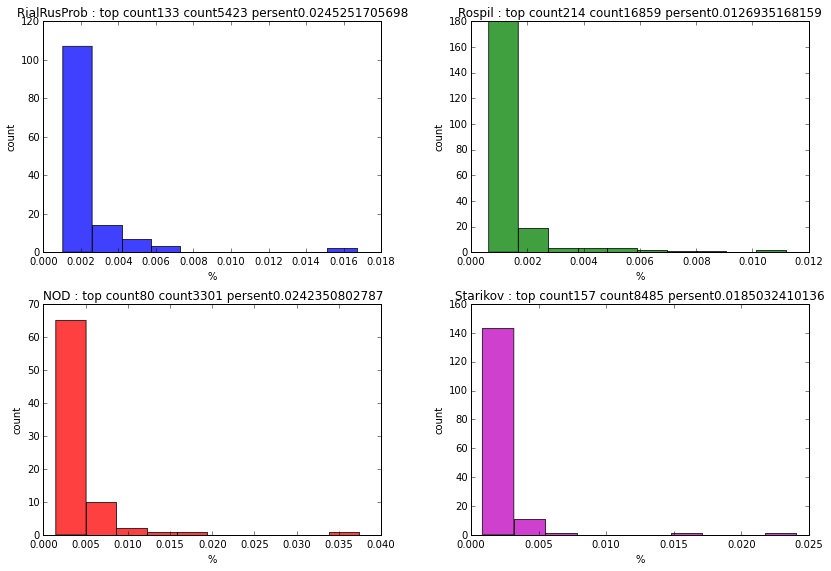

In [94]:
#rrp_posts = get_all_posts_and_comments("realproblemsrussia")
#nod_posts = get_all_posts_and_comments("rusnod")
#ros_posts = get_all_posts_and_comments("rospil")
#star_posts = get_all_posts_and_comments("nstarikov_club")

fig,p1,p2,p3,p4 = get_plots(4,figsize=(12,8),layout=(2,2))
for p in [ (p1,"RialRusProb","b",rrp_posts),(p2,"Rospil","g",ros_posts),(p3,"NOD","r",nod_posts),(p4,"Starikov","m",star_posts) ]:
    pmf = reposters_pmf(p[3]['resposts'].values())
    top_30 = top_reposters_in_30_persent(pmf)
    title = "%s : top count%s count%s persent%s"%(p[1],len(top_30),len(pmf),1.0*len(top_30)/len(pmf))
    
    p[0].set_title(title)
    p[0].set_ylabel('count')
    p[0].set_xlabel('%')
    
    p[0].hist([ v for k,v in pmf.iteritems() if k in  top_30 ],facecolor=p[2], alpha=0.75)
fig.tight_layout()
plt.show()


In [ ]:
len(top_reposters_with_03_persent)

In [ ]:
#text process functions
from nltk.corpus import stopwords
import string
import re
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")
stopwords = stopwords.words('russian')
remove_digits = lambda s: "".join(" " if c in string.digits  else c for c in s)
remove_punct = lambda s: "".join(" " if c in string.punctuation + u'\u2014' + u'\u2013'  else c for c in s)
remove_space = lambda s: " ".join("".join(" " if c in string.whitespace else c for c in s).strip(' ').split())
stem = lambda s: stemmer.stem(s.lower())
full_clean = lambda s: stem(remove_space(remove_punct(s)))


links_re = re.compile(r'((http[s]?|ftp):\/)?\/?([^:\/\s]+)((\/\w+)*\/)([\w\-\.]+[^#?\s]+)([^\s]*)?')
def remove_links(text):
    return re.sub(links_re, '', text)

def words_distribution_of_texts(texts):
    words_friq_dist = {}
    for text in texts:
        text = remove_links(text)
        text = full_clean(remove_digits(text))
        words = text.split()
        for word in words:
            if word in words_friq_dist: words_friq_dist[word] += 1
            else: words_friq_dist[word] = 1
    return sorted([(k,words_friq_dist[k]) for k in words_friq_dist.keys() if k not in stopwords ],key=lambda x:x[1] )
     
        

In [ ]:
rrp_wd = words_distribution_of_texts([ post['text'] for post in rrp_posts[1] ])
nod_wd = words_distribution_of_texts([ post['text'] for post in nod_posts[1] ])
ros_wd = words_distribution_of_texts([ post['text'] for post in ros_posts[1] ])
star_wd = words_distribution_of_texts([ post['text'] for post in star_posts[1] ])

In [ ]:
print rrp_posts[1][191]["text"]

In [ ]:
star_ids_set = set(nf_star_ids)
star_comments = [ x['text'] for x in rrp_posts[1] if x["from_id"] in star_ids_set ]
for x in star_comments[:125]: print x

In [ ]:
import string
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")
remove_punct = lambda s: "".join(" " if c in string.punctuation else c for c in s)
remove_space = lambda s: " ".join("".join(" " if c in string.whitespace else c for c in s).strip(' ').split())
stem = lambda s: stemmer.stem(s.lower())
full_clean = lambda s: stem(remove_space(remove_punct(s)))

print rrp_posts[0][1]['text']

In [ ]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")
komi_put = [ stemmer.stem(i['text']) for i in komi_comments if u'путин' in stemmer.stem(i['text']) ]


In [ ]:
print komi_put[5].split()[1]

In [ ]:


import concurrent.futures
def getWall(id,api):
    return api('wall.get', owner_id=id,count=100)
    
def getWallsIds(ids):
    wals = []
    not_resp_ids = []
    api = vk.API(access_token=token)
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        # Start the load operations and mark each future with its URL
        future_to_url = {executor.submit(getWall, id,api): id for id in ids}
        for future in concurrent.futures.as_completed(future_to_url):
            eid = future_to_url[future]
            try:
                data = future.result()
            except Exception as exc:
                not_resp_ids += [eid]
            else:
                wals += [data]
        return wals,not_resp_ids

def getWallsIdsBL(ids):
    wals = []
    not_resp_ids = []
    while len(ids)>0:
        time.sleep(2)
        wals_,not_resp_ids_=getWallsIds(ids[:9])
        wals += wals_
        not_resp_ids += not_resp_ids_
        ids=ids[9:]
        if len(ids)%300==0:
            print 2000-len(ids),len(not_resp_ids)
    return wals,not_resp_ids